In [142]:
import warnings
warnings.filterwarnings('ignore')

In [143]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow as keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.regularizers import l2
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Embedding, SimpleRNN, Dense, Dropout, LSTM, Bidirectional, Input
from keras.layers import Attention, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import stanza
from keras.utils import to_categorical
from keras.layers import BatchNormalization, Dropout

*<h3>Load Data<h3>*

In [144]:
# read csv file into pandas
df = pd.read_csv("../datasets/shuffled1.csv")
df.head(10)

,question_id,answer,grade
0,1,النبي -صلى الله عليه وسلم- وُلِدَ في سنة الفيل...,2
1,1,وُلِدَ النبي محمد في العام 572 هجريًا,1
2,1,في عام 571، وُلِدَ الرسول -صلى الله عليه وسلم-,2
3,1,رؤية النور كانت في عام 572 ميلادي,1
4,1,ولد رسول الله صلى الله عليه وسلم في العام العا...,0
5,1,ولد رسول الله صلى الله عليه وسلم في العام الخا...,0
6,1,وُلِدَ رسول الله في سنة الفيل المباركة,2
7,1,ولد النبي محمد صلى الله عليه وسلم في مكة المكر...,1
8,1,السنة الفيلية شهدت وُلادة النبي -صلى الله عليه...,2
9,1,رؤية النور في عام 570 هجريًا,1


*<h3>EDA<h3>*

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  110 non-null    int64 
 1   answer       110 non-null    object
 2   grade        110 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 2.7+ KB


In [146]:
df.groupby('grade').size()

grade
0    27
1    41
2    42
dtype: int64

In [147]:
df.duplicated().sum()

0

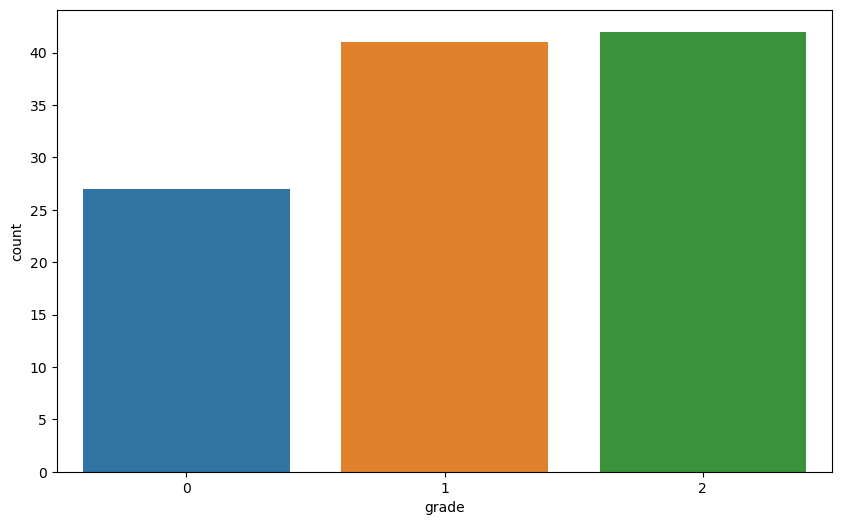

In [148]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='grade')
plt.show()

*<h3>Data Cleaning<h3>*

In [149]:
df.drop('question_id', axis=1, inplace=True)

In [150]:
df.dropna(inplace=True)

In [151]:
df.drop_duplicates(inplace=True)
print(df['answer'])

0      النبي -صلى الله عليه وسلم- وُلِدَ في سنة الفيل...
1                  وُلِدَ النبي محمد في العام 572 هجريًا
2         في عام 571، وُلِدَ الرسول -صلى الله عليه وسلم-
3                      رؤية النور كانت في عام 572 ميلادي
4      ولد رسول الله صلى الله عليه وسلم في العام العا...
                             ...                        
105     رسول الله صلى الله عليه وسلم ولد في مدينة الطائف
106     النبي -صلى الله عليه وسلم- وُلِدَ في مكة المكرمة
107    رسول الله صلى الله عليه وسلم ولد في مكة المكرم...
108    في سنة الفيل وُلِدَ النبي الكريم -صلى الله علي...
109    ولد رسول الله صلى الله عليه وسلم في السابع عشر...
Name: answer, Length: 110, dtype: object


*<h3>Data Pre-Preocessing<h3>*

In [152]:
le = LabelEncoder()
df['grade'] = le.fit_transform(df['grade'])

stanza.download('ar')
nlp = stanza.Pipeline('ar')

def preprocess_text(text):
    doc = nlp(text)
    tokens = [word.lemma for sent in doc.sentences for word in sent.words if word.upos != 'PUNCT']
    return tokens

df['answer'] = df['answer'].apply(preprocess_text)

2024-01-09 21:24:38 INFO: Downloading default packages for language: ar (Arabic) ...
2024-01-09 21:24:39 INFO: File exists: C:\Users\amine\stanza_resources\ar\default.zip
2024-01-09 21:24:43 INFO: Finished downloading models and saved to C:\Users\amine\stanza_resources.
2024-01-09 21:24:43 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-01-09 21:24:46 INFO: Loading these models for language: ar (Arabic):
| Processor | Package       |
-----------------------------
| tokenize  | padt          |
| mwt       | padt          |
| pos       | padt_charlm   |
| lemma     | padt_nocharlm |
| depparse  | padt_charlm   |
| ner       | aqmar_charlm  |

2024-01-09 21:24:46 INFO: Using device: cpu
2024-01-09 21:24:46 INFO: Loading: tokenize
2024-01-09 21:24:46 INFO: Loading: mwt
2024-01-09 21:24:46 INFO: Loading: pos
2024-01-09 21:24:46 INFO: Loading: lemma
2024-01-09 21:24:46 INFO: Loading: depparse
2024-01-09 21:24:47 INFO: Loading: ner
2024-01-09 21:24:47 INFO: Done loading processors!


In [153]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['answer'])
sequences = tokenizer.texts_to_sequences(df['answer'])
max_sequence_length = max(len(s) for s in sequences)
sequences = pad_sequences(sequences,max_sequence_length)
word2idx = tokenizer.word_index
vocab_size = len(word2idx) + 1


X = pad_sequences(sequences, padding='post', truncating='post', maxlen=max_sequence_length)

print(sequences)
print(df['answer'])

Y = to_categorical(df['grade'], num_classes=3)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)


[[ 0  0  0 ... 14 17 50]
 [ 0  0  0 ...  8 31 34]
 [ 0  0  0 ...  4  1  7]
 ...
 [ 0  0  0 ... 12  8 16]
 [ 0  0  0 ...  4  1  7]
 [ 0  0  0 ... 28 35 36]]
0      [النبي, صَلَّى, الله, عَلَى, هُوَ, وَ, سَلَّم,...
1      [وَ, أَل<َاد, النبي, محمد, فِي, عَام, 572, هِج...
2      [فِي, عَام, 571, وَ, أَل<َاد, الرسول, صَلَّى, ...
3       [رُؤيَة, النور, كَان, فِي, عَام, 572, مِيلَادِي]
4      [وَ, لَدّ, رَسُول, الله, صَلَّى, الله, عَلَى, ...
                             ...                        
105    [رَسُول, الله, صَلَّى, الله, عَلَى, هُوَ, وَ, ...
106    [النبي, صَلَّى, الله, عَلَى, هُوَ, وَ, سَلَّم,...
107    [رَسُول, الله, صَلَّى, الله, عَلَى, هُوَ, وَ, ...
108    [فِي, سَنَة, فِيل, وَ, أَل<َاد, النبي, كَرِيم,...
109    [وَ, لَدّ, رَسُول, الله, صَلَّى, الله, عَلَى, ...
Name: answer, Length: 110, dtype: object


*<h3>build Models<h3>*

*<h4>RNN Model<h4>*

In [154]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X, Y, test_size=0.2)

def RNN_model(vocab_size, sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length))
    model.add(SimpleRNN(units=128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(SimpleRNN(units=64, activation='sigmoid'))
    model.add(Dense(256, activation='sigmoid', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)
#EMBEDDING_DIM = 110
rnn_model = RNN_model(vocab_size, max_sequence_length)
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_updated_rnn = rnn_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=100, batch_size=64, callbacks=[reduce_lr])

# Evaluate the RNN model
evaluation_metrics_updated_rnn = rnn_model.evaluate(X_test, Y_test)
print("Evaluation Metrics for RNN:")
for metric_name, metric_value in zip(rnn_model.metrics_names, evaluation_metrics_updated_rnn):
    print(f"{metric_name}: {metric_value}")

Epoch 1/100
2/2 [==============================] - 4s 634ms/step - loss: 1.4511 - accuracy: 0.2955 - val_loss: 1.1860 - val_accuracy: 0.4091 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 144ms/step - loss: 1.2105 - accuracy: 0.3295 - val_loss: 1.2321 - val_accuracy: 0.2727 - lr: 0.0010
Epoch 3/100
1/2 [==============>...............] - ETA: 0s - loss: 1.2153 - accuracy: 0.4219
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2/2 [==============================] - 0s 76ms/step - loss: 1.1307 - accuracy: 0.4886 - val_loss: 1.3166 - val_accuracy: 0.2727 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 51ms/step - loss: 1.1910 - accuracy: 0.4432 - val_loss: 1.3234 - val_accuracy: 0.2727 - lr: 2.0000e-04
Epoch 5/100
1/2 [==============>...............] - ETA: 0s - loss: 1.3151 - accuracy: 0.3438
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001.
2/2 [==============================] - 0s 55ms/step - loss: 1.2587 - a

*<h4>LSTM Model<h4>*

In [155]:
def LSTM_model(vocab_size, sequence_length):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=sequence_length))
    model.add(LSTM(units=128, activation='relu', return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, activation='relu'))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


#EMBEDDING_DIM = 110
lstm_model = LSTM_model(vocab_size, max_sequence_length)
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_updated_rnn = lstm_model.fit(X_train_rnn, y_train_rnn, validation_data=(X_test_rnn, y_test_rnn), epochs=100, batch_size=64, callbacks=[early_stopping_rnn])


# Evaluate the lstm model
evaluation_metrics_updated_lstm = lstm_model.evaluate(X_test, Y_test)
print("Evaluation Metrics for LSTM:")
for metric_name, metric_value in zip(lstm_model.metrics_names, evaluation_metrics_updated_lstm):
    print(f"{metric_name}: {metric_value}")

    

Epoch 1/100
2/2 [==============================] - 5s 672ms/step - loss: 1.1992 - accuracy: 0.3068 - val_loss: 1.1971 - val_accuracy: 0.5455
Epoch 2/100
2/2 [==============================] - 0s 81ms/step - loss: 1.1527 - accuracy: 0.4886 - val_loss: 1.1948 - val_accuracy: 0.3182
Epoch 3/100
2/2 [==============================] - 0s 77ms/step - loss: 1.1213 - accuracy: 0.5114 - val_loss: 1.1911 - val_accuracy: 0.4091
Epoch 4/100
2/2 [==============================] - 0s 79ms/step - loss: 1.0572 - accuracy: 0.5227 - val_loss: 1.1866 - val_accuracy: 0.4091
Epoch 5/100
2/2 [==============================] - 0s 75ms/step - loss: 1.0020 - accuracy: 0.5909 - val_loss: 1.1826 - val_accuracy: 0.4091
Epoch 6/100
2/2 [==============================] - 0s 79ms/step - loss: 0.9383 - accuracy: 0.6591 - val_loss: 1.1795 - val_accuracy: 0.4091
Epoch 7/100
2/2 [==============================] - 0s 75ms/step - loss: 0.8107 - accuracy: 0.7159 - val_loss: 1.1755 - val_accuracy: 0.4091
Epoch 8/100
2/2 [==

*<h4>TRANSFORMER Model<h4>*

In [156]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, density, rate=0.1, l2_reg=0.01):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(density, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
            layers.Dense(embed_dim, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def build_transformer_model(maxlen, vocab_size, embed_dim, num_heads, density, transformer_units, mlp_units, dropout_rate, num_classes):
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    for _ in range(transformer_units):
        x = TransformerBlock(embed_dim, num_heads, density, rate=dropout_rate)(x)
    x = layers.GlobalAveragePooling1D()(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [157]:
maxlen = max_sequence_length
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 120
num_heads = 2
density = 3
transformer_units = 4
mlp_units = [128]
dropout_rate = 0.5
num_classes = len(df['grade'].unique())

transformer_model = build_transformer_model(maxlen, vocab_size, embed_dim, num_heads, density, transformer_units, mlp_units, dropout_rate, num_classes)


In [158]:
transformer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transformer_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))
history = transformer_model.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/30
3/3 [==============================] - 14s 709ms/step - loss: 1.6633 - accuracy: 0.3656 - val_loss: 1.5926 - val_accuracy: 0.2941
Epoch 2/30
3/3 [==============================] - 0s 102ms/step - loss: 1.6263 - accuracy: 0.3656 - val_loss: 1.5484 - val_accuracy: 0.4118
Epoch 3/30
3/3 [==============================] - 0s 81ms/step - loss: 1.6045 - accuracy: 0.3871 - val_loss: 1.4988 - val_accuracy: 0.4118
Epoch 4/30
3/3 [==============================] - 0s 101ms/step - loss: 1.6122 - accuracy: 0.3441 - val_loss: 1.6155 - val_accuracy: 0.2941
Epoch 5/30
3/3 [==============================] - 0s 83ms/step - loss: 1.5242 - accuracy: 0.4086 - val_loss: 1.3933 - val_accuracy: 0.4706
Epoch 6/30
3/3 [==============================] - 0s 143ms/step - loss: 1.3555 - accuracy: 0.5806 - val_loss: 1.4090 - val_accuracy: 0.5294
Epoch 7/30
3/3 [==============================] - 0s 105ms/step - loss: 1.2691 - accuracy: 0.5699 - val_loss: 1.4024 - val_accuracy: 0.4706
Epoch 8/30
3/3 [=====

In [159]:
evaluation_metrics_transformer = transformer_model.evaluate(X_test, Y_test)
print("Evaluation Metrics Transformer:")
for metric_name, metric_value in zip(transformer_model.metrics_names, evaluation_metrics_transformer):
    print(f"{metric_name}: {metric_value}")


1/1 [==============================] - 0s 80ms/step - loss: 1.6596 - accuracy: 0.8235
Evaluation Metrics Transformer:
loss: 1.659584403038025
accuracy: 0.8235294222831726


In [160]:
evaluation_metrics_transformer = transformer_model.evaluate(X_test, Y_test)

predictions = transformer_model.predict(X_test)
print(X_test)

# Convert one-hot encoded labels to class indices
y_true = np.argmax(Y_test, axis=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(predictions, axis=1)

# Create DataFrame
results_df = pd.DataFrame({"Real": y_true, "Predicted": y_pred})

# Display DataFrame
print("\nReal and Predicted Values:")
print(results_df)


1/1 [==============================] - 1s 794ms/step
[[ 0  0  0  0  0  0  0  0  0  1  9 19  5  2  6  4  1  7  3  8 21 49]
 [ 0  0  0  0  0  0  0  0  0 29 19  5  2  6  4  1  7 37  3 14 15 22]
 [ 0  0  0  0  0  1  9 10  2  5  2  6  4  1  7  3  8 41 28 42  4 43]
 [ 0  0  0  0  0  0  0  0  0  0  1 18 40  5  2  6  4  1  7  3  8 16]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1 18 13  3  8 55 74 14 15 75]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 32 30  3  8 16 27]
 [ 1 47 13  5  2  6  4  1  7  3 53 25 28 54 35 36  3 63 64 28  8 17]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3 22  1 47 13]
 [ 0  0  0  0  0  0 10  2  5  2  6  4  1  7  1  9  3 59 25 28 35 36]
 [ 0  0  0  0  0  1  9 13 23  5  2  6  4  1  7  3 11 12  3  8 21 27]
 [ 0  0  0  0  0  0  1  9 13 23  5  2  6  4  1  7  3 11 12  3  8 17]
 [ 0  0  0  0  0  0  1  9 10  2  5  2  6  4  1  7  3 11 12  3  8 16]
 [ 0  0  0  0  0  0  0  0  0 13  5  2  6  4  1  7  1 26  3 14 17 50]
 [ 0  0  0  0  0  0  0 10  2  5  2  6  4  1  7  1 

In [161]:
# Evaluate RNN model
rnn_accuracy = rnn_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy RNN:", rnn_accuracy)

# Evaluate LSTM model
lstm_accuracy = lstm_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy LSTM:", lstm_accuracy)

# Evaluate Transformer model
transformer_accuracy = transformer_model.evaluate(X_test, Y_test, verbose=0)[1]
print("Accuracy Transformer:", transformer_accuracy)



Accuracy RNN: 0.7647058963775635
Accuracy LSTM: 0.8823529481887817
Accuracy Transformer: 0.8235294222831726


In [162]:
# Determine the best model
best_model_name, best_model_accuracy = max([('RNN', rnn_accuracy), ('LSTM', lstm_accuracy), ('Transformer', transformer_accuracy)], key=lambda x: x[1])

save_path = './savedModels/q1_model.h5'
# Save the best model
if best_model_name == 'RNN':
    rnn_model.save(save_path)
elif best_model_name == 'LSTM':
    lstm_model.save(save_path)
elif best_model_name == 'Transformer':
    transformer_model.save(save_path)

print(f"The best model ({best_model_name}) with accuracy {best_model_accuracy} has been saved to '{save_path}'")


The best model (LSTM) with accuracy 0.8823529481887817 has been saved to './savedModels/q1_model.h5'


In [165]:
ls = 'عام الفيل، 571 ميلادي '
ls = preprocess_text(ls)
tn = []
tn.append(ls)
print(tn)
# Preprocess the Arabic sentence
tokenizert = Tokenizer()
tokenizert.fit_on_texts(tn)
sequencest = tokenizert.texts_to_sequences(tn)
sequencest = pad_sequences(sequencest,max_sequence_length)
word2idx = tokenizert.word_index
vocab_size = len(word2idx) + 1


XX = pad_sequences(sequencest, padding='post', truncating='post', maxlen=max_sequence_length)

var = lstm_model.predict(XX)

print(XX)
print(var)
print(int(np.argmax(var, axis=1)[0]))

[['عَام', 'الفيل', '571', 'مِيلَادِي']]
1/1 [==============================] - 0s 28ms/step
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 3 4]]
[[0.34592092 0.27280077 0.3812784 ]]
2
